## Multi-Class Text Classification with Doc2Vec & Logistic Regression
##### The goal is to classify consumer finance complaints into 12 pre-defined classes using Doc2Vec and Logistic Regression

This example is an example posted in Towards Data Science, found here - https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

This example utilizes Doc2Vec to take freeform customer text and classify text into one of 12 distinct categories.  While the model ultimately used could be different, for example a linear or ridge regression approach, this notebook simply documents that process and replicates it

It is worth noting that the dataset used here is quite large, at 696.3mb  This file is not included in the repository here, but can be downloaded from https://catalog.data.gov/dataset/consumer-complaint-database if you wish to experiment with it.

*Notice:* Running this locally with the file limited to 50,000 rows still takes approximately 15 minutes for the whole notebook to run on a MacBook Air with a 2.2 GHz processor and 8GB of memory.  Be aware that running the entire training set can take a moment, and plan accordingly.

In [26]:
import numpy as np
import pandas as pd
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

# We'll need these for text processing
import bs4
from bs4 import BeautifulSoup
import nltk
from nltk.corpus import stopwords

# If you intend to run this locally, you'll need the punkt tokenizer.  
# Uncomment this for the first run you do
# nltk.download('punkt')

import multiprocessing

import gensim
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score

import re
import seaborn as sns
import matplotlib.pyplot as plt


Now that we've got our libraries imported, let's pull in the data.  If you needed to download the data, be sure to move it to the correct relative past for `pd.read_csv()`   Depending on the machine you're running this on, this cell may take a little while as the dataset is quite large.

In [18]:
# Check that this filepath is correct - point it to the local copy of the dataset

df = pd.read_csv('data/example_sets/large_data/Consumer_Complaints.csv',
                 
    # Specify datatypes for efficiency
    dtype={"Date received": str, 
           "Product": str, 
           "Sub-product": str, 
           "Consumer complaint narrative": str, 
           "Company public response": str, 
           "State": str, 
           "ZIP code": str, 
           "Tags": str, 
           "Consumer consent provided?": str, 
           "Submitted via": str, 
           "Date sent to company": str, 
           "Timely response?": str, 
           "Consumer disputed?": str, 
           "Complaint ID": int})

# Select the subset of narrative and product only
df = df[['Consumer complaint narrative','Product']]

# Select the non-null rows of that dataframe
df = df[pd.notnull(df['Consumer complaint narrative'])]

# For testing and easy runtime, we're going to pare this down to the first 50,000 rows
df = df[:50000]

# Rename the columns to a simpler column title
df.rename(columns = {'Consumer complaint narrative':'narrative'}, inplace = True)

# Preview it to make sure we're getting the right stuff
df.head(5)

/Users/romanrheingans-carrion/Documents/siop_ml/siop/lib/python3.5/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,narrative,Product
561,XXXX has been non-compliant with removing the ...,"Credit reporting, credit repair services, or o..."
806,In XX/XX/2012 there was a XXXX card opened und...,"Credit reporting, credit repair services, or o..."
910,The Family Support Service Department has put ...,"Credit reporting, credit repair services, or o..."
925,The Family Support Service Department has put ...,"Credit reporting, credit repair services, or o..."
936,"In XX/XX/2019, I sent a debt validation letter...",Debt collection


In [19]:
# Ensure that removing null rows hasn't messed us up
number_of_rows = df.shape

print(number_of_rows)

(50000, 2)


In [20]:
# The example provided has this value hard coded, but let's use the output of that function instead
df.index = range(number_of_rows[0])

# Let's see how many words there are by splitting the entire set and summing the number of words
df['narrative'].apply(lambda x: len(x.split(' '))).sum()

9837498

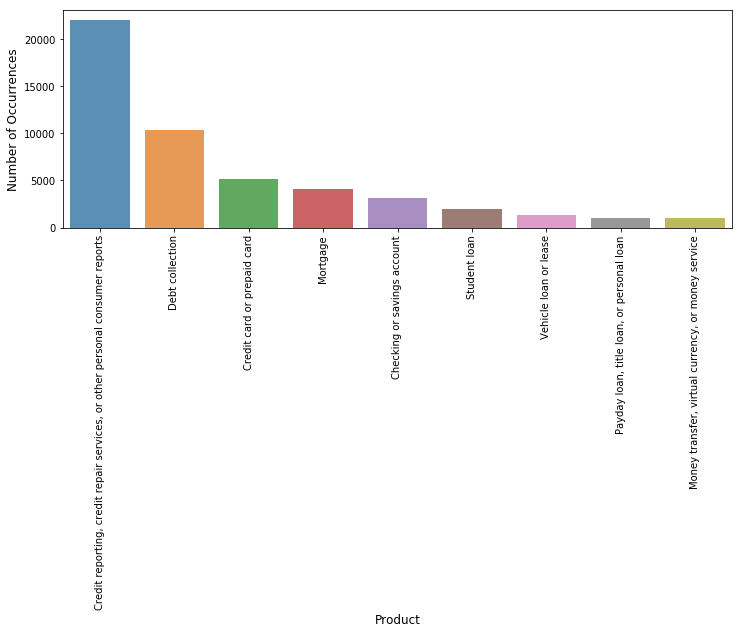

In [21]:
# Chart wizardry.  No need to fuss with this, but this section sets the details of the chart below
cnt_pro = df['Product'].value_counts()
plt.figure(figsize=(12,4))
sns.barplot(cnt_pro.index, cnt_pro.values, alpha=0.8)
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Product', fontsize=12)
plt.xticks(rotation=90)

# Actually show the chart
plt.show();

As the article notes, the stark imbalance of classes here could cause trouble for a model.

In [22]:
def print_complaint(index):
    example = df[df.index == index][['narrative', 'Product']].values[0]
    if len(example) > 0:
        print(example[0])
        print('Product:', example[1])
        
print_complaint(12)

I am a victim of Identity theft/fraud. 
I have notified this collection company/original creditor several times that the account does not belong to me, I have not in any way received goods or services from this company and I have provided my police reports, my FTC id theft AFFIDAVIT signed and notarized along with my sworn statement regarding the fraudulent account. 
documents submitted to XXXX XXXX XXXX, XXXX XXXX, XXXX XXXX, XXXX XXXX XXXX, XXXX XXXX, XXXX, TRANSUNION AND XXXX  XX/XX/2018, includes affidavit, police report, sworn statement w/ signed signature receipt XX/XX/2018, includes affidavit, police report, sworn statement w/ signed signature receipt XX/XX/2018, includes affidavit, police report, sworn statement w/ signed signature receipt This company is in violation of the FCRA. XXXX XXXX XXXX, XXXX XXXX, XXXX XXXX, XXXX XXXX XXXX, XXXX XXXX XXXX, TRANSUNION AND XXXX   continue to report this fraudulent account on my credit report although I have provided these documents with


## Text Processing


In order to ensure that we're not training on unimportant aspects of the text, we'll want to prepare it somewhat.  Things like converting all links into a standard format with `<URL>` so that the model doesn't read into all of the different URL's as meaningful.

In [23]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

# Re-assign the narrative column to itself after applyign the cleanText function
df['narrative'] = df['narrative'].apply(cleanText)

While preparing the text is a good thing to do now, we're at the point where we are ready to start trying to convert the text into trainable features, and for this, we'll want to be able to test out of the main dataset so that we can actually determine how effective the model is.

In [24]:
# Generate our testing and training sets.  Of course, random is 42
train, test = train_test_split(df, test_size=0.3, random_state=42)

Tokenization is the process of turning each sentence in our dataset into a stand alone token.  We are able to determine words and their distinct meaning naturally, however for a machine to understand what the smallest unit of meaning is, we'll need to translate them into meaningful tokens for training.

There are a number of different approaches and techniques to tokenization, however for this example we're using the basic function with NLTK's `word_tokenize()` and the standard stopword library.  The example provided by TDS does not actually call this libary however we could do this by adding `stopwords=english` or pointing it to a customized list of relevant stopwords.

In [25]:
# Create our function that will tokenize each row
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 2:
                continue
            tokens.append(word.lower())
    return tokens

# We'll want to run the same tokenization process on our training and test sets.  This may take a minute.

train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)

test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['narrative']), tags=[r.Product]), axis=1)


## Training the Model

Up to this point we've been doing data preparation and now that the words are split up, we'll want to start vectorizing them.  This will convert the strings themselves into a vectors, which can have other interesting spatial conversions applied to them.

In [27]:
# Set the number of cores available for parallel processing.  
cores = multiprocessing.cpu_count()

model_dbow = Doc2Vec(
    dm=0, 
    vector_size=300, 
    negative=5, 
    hs=0, 
    min_count=2, 
    sample = 0, 
    workers=cores)

model_dbow.build_vocab([x for x in tqdm(train_tagged.values)])

100%|██████████| 35000/35000 [00:00<00:00, 1738705.45it/s]


During this phase, 

In [31]:
model_dmm = Doc2Vec(dm=1, dm_mean=1, vector_size=300, window=10, negative=5, min_count=1, workers=5, alpha=0.065, min_alpha=0.065)
model_dmm.build_vocab([x for x in tqdm(train_tagged.values)])


100%|██████████| 35000/35000 [00:00<00:00, 1156602.69it/s]


In [32]:
%%time
for epoch in range(30):
    model_dmm.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    model_dmm.alpha -= 0.002
    model_dmm.min_alpha = model_dmm.alpha

100%|██████████| 35000/35000 [00:00<00:00, 1975144.50it/s]


CPU times: user 12min 38s, sys: 31.3 s, total: 13min 9s
Wall time: 5min 9s


In [38]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    targets, regressors = zip(*[(doc.tags[0], model.infer_vector(doc.words, steps=20)) for doc in sents])
    return targets, regressors


In [39]:
y_train, X_train = vec_for_learning(model_dbow, train_tagged)
y_test, X_test = vec_for_learning(model_dbow, test_tagged)
logreg = LogisticRegression(n_jobs=1, C=1e5)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

from sklearn.metrics import accuracy_score, f1_score

print('Testing accuracy %s' % accuracy_score(y_test, y_pred))
print('Testing F1 score: {}'.format(f1_score(y_test, y_pred, average='weighted')))

/Users/romanrheingans-carrion/Documents/siop_ml/siop/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/romanrheingans-carrion/Documents/siop_ml/siop/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


Testing accuracy 0.4368
Testing F1 score: 0.29509100235603763


/Users/romanrheingans-carrion/Documents/siop_ml/siop/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [ ]:

# logreg.predict()